In [6]:
#debugging
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, clone_model
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
import matplotlib.pyplot as plt
import json

# Define a custom callback to print messages and store history
class PrintLogger(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"\nEpoch {epoch + 1} started.")
    
    def on_epoch_end(self, epoch, logs=None):
        print(f"\nEpoch {epoch + 1} ended.")
        print(f"Accuracy: {logs['accuracy']:.4f} - Loss: {logs['loss']:.4f} - Val Accuracy: {logs['val_accuracy']:.4f} - Val Loss: {logs['val_loss']:.4f}")

# Define directories
save_dir = './split_datav4'
os.makedirs(save_dir, exist_ok=True)

# Load the split data
X_rp_train = np.load(os.path.join(save_dir, 'X_rp_train.npy'))
X_gaf_train = np.load(os.path.join(save_dir, 'X_gaf_train.npy'))
X_mtf_train = np.load(os.path.join(save_dir, 'X_mtf_train.npy'))
y_train = np.load(os.path.join(save_dir, 'y_train.npy'))

X_rp_val = np.load(os.path.join(save_dir, 'X_rp_val.npy'))
X_gaf_val = np.load(os.path.join(save_dir, 'X_gaf_val.npy'))
X_mtf_val = np.load(os.path.join(save_dir, 'X_mtf_val.npy'))
y_val = np.load(os.path.join(save_dir, 'y_val.npy'))

X_rp_test = np.load(os.path.join(save_dir, 'X_rp_test.npy'))
X_gaf_test = np.load(os.path.join(save_dir, 'X_gaf_test.npy'))
X_mtf_test = np.load(os.path.join(save_dir, 'X_mtf_test.npy'))
y_test = np.load(os.path.join(save_dir, 'y_test.npy'))

# Resize images to (224, 224, 3) and keep only RGB channels
def resize_images(images):
    resized_images = []
    for img in images:
        img = tf.image.resize(img, [224, 224])
        img = img[:, :, :3]  # Keep only RGB channels
        resized_images.append(img)
    return np.array(resized_images)

X_rp_train = resize_images(X_rp_train)
X_gaf_train = resize_images(X_gaf_train)
X_mtf_train = resize_images(X_mtf_train)
X_rp_val = resize_images(X_rp_val)
X_gaf_val = resize_images(X_gaf_val)
X_mtf_val = resize_images(X_mtf_val)
X_rp_test = resize_images(X_rp_test)
X_gaf_test = resize_images(X_gaf_test)
X_mtf_test = resize_images(X_mtf_test)

# Define a function to build the VGG16 model
def build_vgg16_model(input_shape, num_classes):
    inputs_rp = Input(shape=input_shape, name='input_rp')
    inputs_gaf = Input(shape=input_shape, name='input_gaf')
    inputs_mtf = Input(shape=input_shape, name='input_mtf')

    base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

    # Clone the base model for each input with unique names
    base_rp = clone_model(base_model)
    base_rp._name = 'base_rp'
    base_rp.set_weights(base_model.get_weights())
    x_rp = base_rp(inputs_rp)
    x_rp = Flatten(name='flatten_rp')(x_rp)

    base_gaf = clone_model(base_model)
    base_gaf._name = 'base_gaf'
    base_gaf.set_weights(base_model.get_weights())
    x_gaf = base_gaf(inputs_gaf)
    x_gaf = Flatten(name='flatten_gaf')(x_gaf)

    base_mtf = clone_model(base_model)
    base_mtf._name = 'base_mtf'
    base_mtf.set_weights(base_model.get_weights())
    x_mtf = base_mtf(inputs_mtf)
    x_mtf = Flatten(name='flatten_mtf')(x_mtf)

    merged = Concatenate(name='concat')([x_rp, x_gaf, x_mtf])

    x = Dense(512, activation='relu', name='dense_512')(merged)
    x = Dropout(0.5, name='dropout_512')(x)
    x = Dense(128, activation='relu', name='dense_128')(x)
    x = Dropout(0.5, name='dropout_128')(x)
    outputs = Dense(num_classes, activation='softmax', name='output')(x)

    model = Model(inputs=[inputs_rp, inputs_gaf, inputs_mtf], outputs=outputs)
    return model

# Define input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 5

# Build VGG16 model
vgg16_model = build_vgg16_model(input_shape, num_classes)
vgg16_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
vgg16_checkpoint = ModelCheckpoint(filepath=os.path.join(save_dir, 'vgg16_best_model.keras'), monitor='val_loss', save_best_only=True)

# Train VGG16 model
vgg16_history = vgg16_model.fit(
    [X_rp_train, X_gaf_train, X_mtf_train], y_train,
    epochs=10, batch_size=32, validation_data=([X_rp_val, X_gaf_val, X_mtf_val], y_val),
    callbacks=[early_stopping, vgg16_checkpoint, PrintLogger()],
    verbose=1
)

# Evaluate VGG16 model on the test set
vgg16_model.load_weights(os.path.join(save_dir, 'vgg16_best_model.keras'))
vgg16_test_loss, vgg16_test_accuracy = vgg16_model.evaluate([X_rp_test, X_gaf_test, X_mtf_test], y_test)
print(f'VGG16 Test loss: {vgg16_test_loss:.4f}')
print(f'VGG16 Test accuracy: {vgg16_test_accuracy:.4f}')

# Function to plot learning curves
def plot_learning_curve(history, model_name):
    plt.figure(figsize=(12, 8))

    # Plot training & validation accuracy values
    plt.subplot(2, 1, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model accuracy - {model_name}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(2, 1, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model loss - {model_name}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Plot learning curve for VGG16
plot_learning_curve(vgg16_history, 'VGG16')

# Save the final VGG16 model
vgg16_model.save(os.path.join(save_dir, 'vgg16_model.keras'))

# Save the training history
with open(os.path.join(save_dir, 'vgg16_history.json'), 'w') as f:
    json.dump(vgg16_history.history, f)

print(f"VGG16 model and history saved in directory: {save_dir}")


2024-07-03 14:23:46.511699: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.22GiB (rounded to 3454918656)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-07-03 14:23:46.511780: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-07-03 14:23:46.511817: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 47, Chunks in use: 47. 11.8KiB allocated for chunks. 11.8KiB in use in bin. 3.7KiB client-requested in use in bin.
2024-07-03 14:23:46.511831: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 16, Chunks in use: 16. 8.8KiB allocated for chunks. 8.8KiB in use in bin. 8.0KiB client-requested in use in bin.
2024-07-03 14:23:46.5

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [8]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, clone_model
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
import matplotlib.pyplot as plt
import json

# Define a custom callback to print messages and store history
class PrintLogger(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"\nEpoch {epoch + 1} started.")
    
    def on_epoch_end(self, epoch, logs=None):
        print(f"\nEpoch {epoch + 1} ended.")
        print(f"Accuracy: {logs['accuracy']:.4f} - Loss: {logs['loss']:.4f} - Val Accuracy: {logs['val_accuracy']:.4f} - Val Loss: {logs['val_loss']:.4f}")

# Define directories
save_dir = './split_datav4'
os.makedirs(save_dir, exist_ok=True)

# Load the split data
X_rp_train = np.load(os.path.join(save_dir, 'X_rp_train.npy'))
X_gaf_train = np.load(os.path.join(save_dir, 'X_gaf_train.npy'))
X_mtf_train = np.load(os.path.join(save_dir, 'X_mtf_train.npy'))
y_train = np.load(os.path.join(save_dir, 'y_train.npy'))

X_rp_val = np.load(os.path.join(save_dir, 'X_rp_val.npy'))
X_gaf_val = np.load(os.path.join(save_dir, 'X_gaf_val.npy'))
X_mtf_val = np.load(os.path.join(save_dir, 'X_mtf_val.npy'))
y_val = np.load(os.path.join(save_dir, 'y_val.npy'))

X_rp_test = np.load(os.path.join(save_dir, 'X_rp_test.npy'))
X_gaf_test = np.load(os.path.join(save_dir, 'X_gaf_test.npy'))
X_mtf_test = np.load(os.path.join(save_dir, 'X_mtf_test.npy'))
y_test = np.load(os.path.join(save_dir, 'y_test.npy'))

# Resize images to (224, 224, 3) and keep only RGB channels
def resize_images(images):
    def _resize(img):
        img = tf.image.resize(img, [224, 224])
        img = img[:, :, :3]  # Keep only RGB channels
        return img
    
    return tf.data.Dataset.from_tensor_slices(images).map(_resize, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)

# Create TensorFlow Datasets
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices(((X_rp_train, X_gaf_train, X_mtf_train), y_train))
train_dataset = train_dataset.map(lambda x, y: ((resize_images(x[0]), resize_images(x[1]), resize_images(x[2])), y), num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices(((X_rp_val, X_gaf_val, X_mtf_val), y_val))
val_dataset = val_dataset.map(lambda x, y: ((resize_images(x[0]), resize_images(x[1]), resize_images(x[2])), y), num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices(((X_rp_test, X_gaf_test, X_mtf_test), y_test))
test_dataset = test_dataset.map(lambda x, y: ((resize_images(x[0]), resize_images(x[1]), resize_images(x[2])), y), num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

# Define a function to build the VGG16 model
def build_vgg16_model(input_shape, num_classes):
    inputs_rp = Input(shape=input_shape, name='input_rp')
    inputs_gaf = Input(shape=input_shape, name='input_gaf')
    inputs_mtf = Input(shape=input_shape, name='input_mtf')

    base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

    # Clone the base model for each input with unique names
    base_rp = clone_model(base_model)
    base_rp._name = 'base_rp'
    base_rp.set_weights(base_model.get_weights())
    x_rp = base_rp(inputs_rp)
    x_rp = Flatten(name='flatten_rp')(x_rp)

    base_gaf = clone_model(base_model)
    base_gaf._name = 'base_gaf'
    base_gaf.set_weights(base_model.get_weights())
    x_gaf = base_gaf(inputs_gaf)
    x_gaf = Flatten(name='flatten_gaf')(x_gaf)

    base_mtf = clone_model(base_model)
    base_mtf._name = 'base_mtf'
    base_mtf.set_weights(base_model.get_weights())
    x_mtf = base_mtf(inputs_mtf)
    x_mtf = Flatten(name='flatten_mtf')(x_mtf)

    merged = Concatenate(name='concat')([x_rp, x_gaf, x_mtf])

    x = Dense(512, activation='relu', name='dense_512')(merged)
    x = Dropout(0.5, name='dropout_512')(x)
    x = Dense(128, activation='relu', name='dense_128')(x)
    x = Dropout(0.5, name='dropout_128')(x)
    outputs = Dense(num_classes, activation='softmax', name='output')(x)

    model = Model(inputs=[inputs_rp, inputs_gaf, inputs_mtf], outputs=outputs)
    return model

# Define input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 4

# Build VGG16 model
vgg16_model = build_vgg16_model(input_shape, num_classes)
vgg16_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
vgg16_checkpoint = ModelCheckpoint(filepath=os.path.join(save_dir, 'vgg16_best_model.keras'), monitor='val_loss', save_best_only=True)

# Train VGG16 model
vgg16_history = vgg16_model.fit(
    train_dataset,
    epochs=10, validation_data=val_dataset,
    callbacks=[early_stopping, vgg16_checkpoint, PrintLogger()],
    verbose=1
)

# Evaluate VGG16 model on the test set
vgg16_model.load_weights(os.path.join(save_dir, 'vgg16_best_model.keras'))
vgg16_test_loss, vgg16_test_accuracy = vgg16_model.evaluate(test_dataset)
print(f'VGG16 Test loss: {vgg16_test_loss:.4f}')
print(f'VGG16 Test accuracy: {vgg16_test_accuracy:.4f}')

# Function to plot learning curves
def plot_learning_curve(history, model_name):
    plt.figure(figsize=(12, 8))

    # Plot training & validation accuracy values
    plt.subplot(2, 1, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model accuracy - {model_name}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(2, 1, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model loss - {model_name}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Plot learning curve for VGG16
plot_learning_curve(vgg16_history, 'VGG16')

# Save the final VGG16 model
vgg16_model.save(os.path.join(save_dir, 'vgg16_model.keras'))

# Save the training history
with open(os.path.join(save_dir, 'vgg16_history.json'), 'w') as f:
    json.dump(vgg16_history.history, f)

print(f"VGG16 model and history saved in directory: {save_dir}")


ValueError: in user code:

    File "/tmp/ipykernel_31081/953854979.py", line 52, in None  *
        lambda x, y: ((resize_images(x[0]), resize_images(x[1]), resize_images(x[2])), y)
    File "/tmp/ipykernel_31081/953854979.py", line 43, in _resize  *
        img = tf.image.resize(img, [224, 224])

    ValueError: 'images' must have either 3 or 4 dimensions.


In [1]:
#again debug
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, clone_model
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
import matplotlib.pyplot as plt
import json

# Define a custom callback to print messages and store history
class PrintLogger(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"\nEpoch {epoch + 1} started.")
    
    def on_epoch_end(self, epoch, logs=None):
        print(f"\nEpoch {epoch + 1} ended.")
        print(f"Accuracy: {logs['accuracy']:.4f} - Loss: {logs['loss']:.4f} - Val Accuracy: {logs['val_accuracy']:.4f} - Val Loss: {logs['val_loss']:.4f}")

# Define directories
save_dir = './split_datav4'
os.makedirs(save_dir, exist_ok=True)

# Load the split data
X_rp_train = np.load(os.path.join(save_dir, 'X_rp_train.npy'))
X_gaf_train = np.load(os.path.join(save_dir, 'X_gaf_train.npy'))
X_mtf_train = np.load(os.path.join(save_dir, 'X_mtf_train.npy'))
y_train = np.load(os.path.join(save_dir, 'y_train.npy'))

X_rp_val = np.load(os.path.join(save_dir, 'X_rp_val.npy'))
X_gaf_val = np.load(os.path.join(save_dir, 'X_gaf_val.npy'))
X_mtf_val = np.load(os.path.join(save_dir, 'X_mtf_val.npy'))
y_val = np.load(os.path.join(save_dir, 'y_val.npy'))

X_rp_test = np.load(os.path.join(save_dir, 'X_rp_test.npy'))
X_gaf_test = np.load(os.path.join(save_dir, 'X_gaf_test.npy'))
X_mtf_test = np.load(os.path.join(save_dir, 'X_mtf_test.npy'))
y_test = np.load(os.path.join(save_dir, 'y_test.npy'))

# Function to resize images
def resize_images(images):
    def _resize(img):
        img = tf.image.resize(img, [224, 224])
        img = img[:, :, :3]  # Keep only RGB channels
        return img

    dataset = tf.data.Dataset.from_tensor_slices(images)
    dataset = dataset.map(lambda img: _resize(img), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)
    
    resized_images = []
    for batch in dataset:
        resized_images.append(batch)
    
    return np.vstack(resized_images)

X_rp_train = resize_images(X_rp_train)
X_gaf_train = resize_images(X_gaf_train)
X_mtf_train = resize_images(X_mtf_train)
X_rp_val = resize_images(X_rp_val)
X_gaf_val = resize_images(X_gaf_val)
X_mtf_val = resize_images(X_mtf_val)
X_rp_test = resize_images(X_rp_test)
X_gaf_test = resize_images(X_gaf_test)
X_mtf_test = resize_images(X_mtf_test)

# Define a function to build the VGG16 model
def build_vgg16_model(input_shape, num_classes):
    inputs_rp = Input(shape=input_shape, name='input_rp')
    inputs_gaf = Input(shape=input_shape, name='input_gaf')
    inputs_mtf = Input(shape=input_shape, name='input_mtf')

    base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

    # Clone the base model for each input with unique names
    base_rp = clone_model(base_model)
    base_rp._name = 'base_rp'
    base_rp.set_weights(base_model.get_weights())
    x_rp = base_rp(inputs_rp)
    x_rp = Flatten(name='flatten_rp')(x_rp)

    base_gaf = clone_model(base_model)
    base_gaf._name = 'base_gaf'
    base_gaf.set_weights(base_model.get_weights())
    x_gaf = base_gaf(inputs_gaf)
    x_gaf = Flatten(name='flatten_gaf')(x_gaf)

    base_mtf = clone_model(base_model)
    base_mtf._name = 'base_mtf'
    base_mtf.set_weights(base_model.get_weights())
    x_mtf = base_mtf(inputs_mtf)
    x_mtf = Flatten(name='flatten_mtf')(x_mtf)

    merged = Concatenate(name='concat')([x_rp, x_gaf, x_mtf])

    x = Dense(512, activation='relu', name='dense_512')(merged)
    x = Dropout(0.5, name='dropout_512')(x)
    x = Dense(128, activation='relu', name='dense_128')(x)
    x = Dropout(0.5, name='dropout_128')(x)
    outputs = Dense(num_classes, activation='softmax', name='output')(x)

    model = Model(inputs=[inputs_rp, inputs_gaf, inputs_mtf], outputs=outputs)
    return model

# Define input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 4

# Build VGG16 model
vgg16_model = build_vgg16_model(input_shape, num_classes)
vgg16_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
vgg16_checkpoint = ModelCheckpoint(filepath=os.path.join(save_dir, 'vgg16_best_model.keras'), monitor='val_loss', save_best_only=True)

# Create TensorFlow Datasets
batch_size = 4
train_dataset = tf.data.Dataset.from_tensor_slices(((X_rp_train, X_gaf_train, X_mtf_train), y_train)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices(((X_rp_val, X_gaf_val, X_mtf_val), y_val)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices(((X_rp_test, X_gaf_test, X_mtf_test), y_test)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

# Train VGG16 model
vgg16_history = vgg16_model.fit(
    train_dataset,
    epochs=10, validation_data=val_dataset,
    callbacks=[early_stopping, vgg16_checkpoint, PrintLogger()],
    verbose=1
)

# Evaluate VGG16 model on the test set
vgg16_model.load_weights(os.path.join(save_dir, 'vgg16_best_model.keras'))
vgg16_test_loss, vgg16_test_accuracy = vgg16_model.evaluate(test_dataset)
print(f'VGG16 Test loss: {vgg16_test_loss:.4f}')
print(f'VGG16 Test accuracy: {vgg16_test_accuracy:.4f}')

# Function to plot learning curves
def plot_learning_curve(history, model_name):
    plt.figure(figsize=(12, 8))

    # Plot training & validation accuracy values
    plt.subplot(2, 1, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model accuracy - {model_name}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(2, 1, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model loss - {model_name}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Plot learning curve for VGG16
plot_learning_curve(vgg16_history, 'VGG16')

# Save the final VGG16 model
vgg16_model.save(os.path.join(save_dir, 'vgg16_model.keras'))

# Save the training history
with open(os.path.join(save_dir, 'vgg16_history.json'), 'w') as f:
    json.dump(vgg16_history.history, f)

print(f"VGG16 model and history saved in directory: {save_dir}")


2024-07-04 17:08:38.010665: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-04 17:08:38.116155: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-04 17:08:38.116198: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-04 17:08:38.145995: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-04 17:08:38.190122: I tensorflow/core/platform/cpu_feature_guar

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, clone_model
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
import matplotlib.pyplot as plt
import json
import cv2
import logging
import time

LOG_FORMAT = "[%(asctime)s] [%(name)s] [%(levelname)s] %(message)s"
logging.basicConfig(format=LOG_FORMAT)
logging.getLogger("IMG").setLevel(logging.DEBUG)
log = logging.getLogger("IMG")

class ImageBatcher:
    def __init__(self, images, batch_size: int, image_size: int, shuffle: bool, drop_last: bool, max_batch: int = 0) -> None:
        log.info("Initializing image batcher")
        self.images = images
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.drop_last = drop_last
        self.max_batch = max_batch

        self.num_images = self.images.shape[0]
        self.shape = (batch_size, self.images.shape[1], image_size, image_size)
        self.size = int(np.prod(self.shape))
        self.dtype = self.images.dtype
        self.nbytes = self.dtype.itemsize * self.size

        log.debug(f"Image Fields... \
            \n\tNumber of images: {self.num_images} \
            \n\tType: {self.dtype} \
            \n\tBatch Shape: {self.shape} \
            \n\tBatch Size: {self.size} \
            \n\tBatch Bytes: {self.nbytes}")

        self.indices = None
        self.current_index = 0
        self.current_batch = 0
        self.epoch = 0
        self._initialize_indices()

        log.info("Successfully created image batcher")

    def _initialize_indices(self) -> None:
        log.debug(f"Initializing indices. Shuffle: {self.shuffle}")
        self.indices = np.arange(self.num_images)

        if self.shuffle:
            np.random.shuffle(self.indices)

    def __iter__(self):
        return self

    def __next__(self) -> np.ndarray:
        self.current_batch += 1

        if self.current_index >= self.num_images:
            self._batch_completed()
            raise StopIteration
        
        if self.max_batch != 0 and self.current_batch > self.max_batch:
            self._batch_completed()
            raise StopIteration
        
        start_idx = self.current_index
        end_idx = min(self.current_index + self.batch_size, self.num_images)
        batch_indices = self.indices[start_idx: end_idx]

        if self.drop_last and end_idx - start_idx != self.batch_size:
            log.debug("Skipped last batch")
            self._batch_completed()
            raise StopIteration
        
        batch_images = self._get_batch_from_dataset(batch_indices)

        self.current_index = end_idx
        return batch_images

    def _batch_completed(self) -> None:
        log.info("Batch completed")
        self.epoch += 1
        self.current_index = 0
        self.current_batch = 0

        if self.shuffle:
            np.random.shuffle(self.indices)

    def _get_batch_from_dataset(self, indices: list[int]) -> np.ndarray:
        if self.shuffle:
            batch_images = []
            for i in indices:
                batch_images.append(self.images[i])
            
            batch_images = np.stack(batch_images, axis=0)
            return self._preprocess_images(batch_images)
        else:
            batch_images = self.images[indices]
            return self._preprocess_images(batch_images)

    def _preprocess_images(self, images: np.ndarray) -> np.ndarray:
        output_size = (self.image_size, self.image_size)
        resized_images = np.empty((images.shape[0], *output_size, images.shape[3]))
        resized_images = resized_images.astype(self.dtype)

        for i, image in enumerate(images):
            resized_images[i] = cv2.resize(image, output_size, interpolation=cv2.INTER_LINEAR)
        
        return resized_images

# Function to resize images using the ImageBatcher
def resize_images_with_batcher(images, batch_size, image_size, shuffle=False):
    batcher = ImageBatcher(images, batch_size=batch_size, image_size=image_size, shuffle=shuffle, drop_last=False)
    resized_images = []

    for batch in batcher:
        resized_images.append(batch)

    return np.vstack(resized_images)

# Define directories
save_dir = './split_datav4'
os.makedirs(save_dir, exist_ok=True)

# Load the split data
X_rp_train = np.load(os.path.join(save_dir, 'X_rp_train.npy'))
X_gaf_train = np.load(os.path.join(save_dir, 'X_gaf_train.npy'))
X_mtf_train = np.load(os.path.join(save_dir, 'X_mtf_train.npy'))
y_train = np.load(os.path.join(save_dir, 'y_train.npy'))

X_rp_val = np.load(os.path.join(save_dir, 'X_rp_val.npy'))
X_gaf_val = np.load(os.path.join(save_dir, 'X_gaf_val.npy'))
X_mtf_val = np.load(os.path.join(save_dir, 'X_mtf_val.npy'))
y_val = np.load(os.path.join(save_dir, 'y_val.npy'))

X_rp_test = np.load(os.path.join(save_dir, 'X_rp_test.npy'))
X_gaf_test = np.load(os.path.join(save_dir, 'X_gaf_test.npy'))
X_mtf_test = np.load(os.path.join(save_dir, 'X_mtf_test.npy'))
y_test = np.load(os.path.join(save_dir, 'y_test.npy'))

# Resize images using ImageBatcher
X_rp_train = resize_images_with_batcher(X_rp_train, batch_size=32, image_size=224)
X_gaf_train = resize_images_with_batcher(X_gaf_train, batch_size=32, image_size=224)
X_mtf_train = resize_images_with_batcher(X_mtf_train, batch_size=32, image_size=224)
X_rp_val = resize_images_with_batcher(X_rp_val, batch_size=32, image_size=224)
X_gaf_val = resize_images_with_batcher(X_gaf_val, batch_size=32, image_size=224)
X_mtf_val = resize_images_with_batcher(X_mtf_val, batch_size=32, image_size=224)
X_rp_test = resize_images_with_batcher(X_rp_test, batch_size=32, image_size=224)
X_gaf_test = resize_images_with_batcher(X_gaf_test, batch_size=32, image_size=224)
X_mtf_test = resize_images_with_batcher(X_mtf_test, batch_size=32, image_size=224)

# Define a function to build the VGG16 model
def build_vgg16_model(input_shape, num_classes):
    inputs_rp = Input(shape=input_shape, name='input_rp')
    inputs_gaf = Input(shape=input_shape, name='input_gaf')
    inputs_mtf = Input(shape=input_shape, name='input_mtf')

    base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

    base_rp = clone_model(base_model)
    base_rp._name = 'base_rp'
    base_rp.set_weights(base_model.get_weights())
    x_rp = base_rp(inputs_rp)
    x_rp = Flatten(name='flatten_rp')(x_rp)

    base_gaf = clone_model(base_model)
    base_gaf._name = 'base_gaf'
    base_gaf.set_weights(base_model.get_weights())
    x_gaf = base_gaf(inputs_gaf)
    x_gaf = Flatten(name='flatten_gaf')(x_gaf)

    base_mtf = clone_model(base_model)
    base_mtf._name = 'base_mtf'
    base_mtf.set_weights(base_model.get_weights())
    x_mtf = base_mtf(inputs_mtf)
    x_mtf = Flatten(name='flatten_mtf')(x_mtf)

    merged = Concatenate(name='concat')([x_rp, x_gaf, x_mtf])

    x = Dense(512, activation='relu', name='dense_512')(merged)
    x = Dropout(0.5, name='dropout_512')(x)
    x = Dense(128, activation='relu', name='dense_128')(x)
    x = Dropout(0.5, name='dropout_128')(x)
    outputs = Dense(num_classes, activation='softmax', name='output')(x)

    model = Model(inputs=[inputs_rp, inputs_gaf, inputs_mtf], outputs=outputs)
    return model

# Define input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 4

# Build VGG16 model
vgg16_model = build_vgg16_model(input_shape, num_classes)
vgg16_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
vgg16_checkpoint = ModelCheckpoint(filepath=os.path.join(save_dir, 'vgg16_best_model.keras'), monitor='val_loss', save_best_only=True)

# Create TensorFlow Datasets
batch_size = 4
train_dataset = tf.data.Dataset.from_tensor_slices(((X_rp_train, X_gaf_train, X_mtf_train), y_train)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices(((X_rp_val, X_gaf_val, X_mtf_val), y_val)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices(((X_rp_test, X_gaf_test, X_mtf_test), y_test)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

# Train VGG16 model
vgg16_history = vgg16_model.fit(
    train_dataset,
    epochs=10, validation_data=val_dataset,
    callbacks=[early_stopping, vgg16_checkpoint, PrintLogger()],
    verbose=1
)

# Evaluate VGG16 model on the test set
vgg16_model.load_weights(os.path.join(save_dir, 'vgg16_best_model.keras'))
vgg16_test_loss, vgg16_test_accuracy = vgg16_model.evaluate(test_dataset)
print(f'VGG16 Test loss: {vgg16_test_loss:.4f}')
print(f'VGG16 Test accuracy: {vgg16_test_accuracy:.4f}')

# Function to plot learning curves
def plot_learning_curve(history, model_name):
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model accuracy - {model_name}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(2, 1, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model loss - {model_name}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Plot learning curve for VGG16
plot_learning_curve(vgg16_history, 'VGG16')

# Save the final VGG16 model
vgg16_model.save(os.path.join(save_dir, 'vgg16_model.keras'))

# Save the training history
with open(os.path.join(save_dir, 'vgg16_history.json'), 'w') as f:
    json.dump(vgg16_history.history, f)

print(f"VGG16 model and history saved in directory: {save_dir}")


[2024-07-04 20:23:50,888] [IMG] [INFO] Initializing image batcher
[2024-07-04 20:23:50,889] [IMG] [DEBUG] Image Fields...             
	Number of images: 5738             
	Type: uint8             
	Batch Shape: (32, 201, 224, 224)             
	Batch Size: 322732032             
	Batch Bytes: 322732032
[2024-07-04 20:23:50,890] [IMG] [DEBUG] Initializing indices. Shuffle: False
[2024-07-04 20:23:50,890] [IMG] [INFO] Successfully created image batcher
[2024-07-04 20:23:52,162] [IMG] [INFO] Batch completed
[2024-07-04 20:23:52,505] [IMG] [INFO] Initializing image batcher
[2024-07-04 20:23:52,505] [IMG] [DEBUG] Image Fields...             
	Number of images: 5738             
	Type: uint8             
	Batch Shape: (32, 201, 224, 224)             
	Batch Size: 322732032             
	Batch Bytes: 322732032
[2024-07-04 20:23:52,506] [IMG] [DEBUG] Initializing indices. Shuffle: False
[2024-07-04 20:23:52,507] [IMG] [INFO] Successfully created image batcher
/tmp/ipykernel_72591/1954260083.p

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

24:09.001611: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 7fadbc7c8200 of size 288000 next 60
2024-07-04 20:24:09.001619: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 7fadbc80e700 of size 442368 next 62
2024-07-04 20:24:09.001626: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 7fadbc87a700 of size 589824 next 92
2024-07-04 20:24:09.001634: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 7fadbc90a700 of size 1474560 next 66
2024-07-04 20:24:09.001643: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 7fadbca72700 of size 589824 next 59
2024-07-04 20:24:09.001650: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 7fadbcb02700 of size 2048 next 100
2024-07-04 20:24:09.001657: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 7fadbcb02f00 of size 2048 next 107
2024-07-04 20:24:09.001665: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 7fa

In [6]:
#again debugging
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, clone_model
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
import matplotlib.pyplot as plt
import json
import cv2
import logging
import time

LOG_FORMAT = "[%(asctime)s] [%(name)s] [%(levelname)s] %(message)s"
logging.basicConfig(format=LOG_FORMAT)
logging.getLogger("IMG").setLevel(logging.DEBUG)
log = logging.getLogger("IMG")

class ImageBatcher:
    def __init__(self, images, batch_size: int, image_size: int, shuffle: bool, drop_last: bool, max_batch: int = 0) -> None:
        log.info("Initializing image batcher")
        self.images = images
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.drop_last = drop_last
        self.max_batch = max_batch

        self.num_images = self.images.shape[0]
        self.shape = (batch_size, self.images.shape[1], image_size, image_size)
        self.size = int(np.prod(self.shape))
        self.dtype = self.images.dtype
        self.nbytes = self.dtype.itemsize * self.size

        log.debug(f"Image Fields... \
            \n\tNumber of images: {self.num_images} \
            \n\tType: {self.dtype} \
            \n\tBatch Shape: {self.shape} \
            \n\tBatch Size: {self.size} \
            \n\tBatch Bytes: {self.nbytes}")

        self.indices = None
        self.current_index = 0
        self.current_batch = 0
        self.epoch = 0
        self._initialize_indices()

        log.info("Successfully created image batcher")

    def _initialize_indices(self) -> None:
        log.debug(f"Initializing indices. Shuffle: {self.shuffle}")
        self.indices = np.arange(self.num_images)

        if self.shuffle:
            np.random.shuffle(self.indices)

    def __iter__(self):
        return self

    def __next__(self) -> np.ndarray:
        self.current_batch += 1

        if self.current_index >= self.num_images:
            self._batch_completed()
            raise StopIteration
        
        if self.max_batch != 0 and self.current_batch > self.max_batch:
            self._batch_completed()
            raise StopIteration
        
        start_idx = self.current_index
        end_idx = min(self.current_index + self.batch_size, self.num_images)
        batch_indices = self.indices[start_idx: end_idx]

        if self.drop_last and end_idx - start_idx != self.batch_size:
            log.debug("Skipped last batch")
            self._batch_completed()
            raise StopIteration
        
        batch_images = self._get_batch_from_dataset(batch_indices)

        self.current_index = end_idx
        return batch_images

    def _batch_completed(self) -> None:
        log.info("Batch completed")
        self.epoch += 1
        self.current_index = 0
        self.current_batch = 0

        if self.shuffle:
            np.random.shuffle(self.indices)

    def _get_batch_from_dataset(self, indices: list[int]) -> np.ndarray:
        if self.shuffle:
            batch_images = []
            for i in indices:
                batch_images.append(self.images[i])
            
            batch_images = np.stack(batch_images, axis=0)
            return self._preprocess_images(batch_images)
        else:
            batch_images = self.images[indices]
            return self._preprocess_images(batch_images)

    def _preprocess_images(self, images: np.ndarray) -> np.ndarray:
        output_size = (self.image_size, self.image_size)
        resized_images = np.empty((images.shape[0], *output_size, images.shape[3]))
        resized_images = resized_images.astype(self.dtype)

        for i, image in enumerate(images):
            resized_images[i] = cv2.resize(image, output_size, interpolation=cv2.INTER_LINEAR)
        
        return resized_images

# Function to resize images using the ImageBatcher
def resize_images_with_batcher(images, batch_size, image_size, shuffle=False):
    batcher = ImageBatcher(images, batch_size=batch_size, image_size=image_size, shuffle=shuffle, drop_last=False)
    resized_images = []

    for batch in batcher:
        resized_images.append(batch)

    return np.vstack(resized_images)

# Define directories
save_dir = './split_datav4'
os.makedirs(save_dir, exist_ok=True)

# Load the split data
X_rp_train = np.load(os.path.join(save_dir, 'X_rp_train.npy'))
X_gaf_train = np.load(os.path.join(save_dir, 'X_gaf_train.npy'))
X_mtf_train = np.load(os.path.join(save_dir, 'X_mtf_train.npy'))
y_train = np.load(os.path.join(save_dir, 'y_train.npy'))

X_rp_val = np.load(os.path.join(save_dir, 'X_rp_val.npy'))
X_gaf_val = np.load(os.path.join(save_dir, 'X_gaf_val.npy'))
X_mtf_val = np.load(os.path.join(save_dir, 'X_mtf_val.npy'))
y_val = np.load(os.path.join(save_dir, 'y_val.npy'))

X_rp_test = np.load(os.path.join(save_dir, 'X_rp_test.npy'))
X_gaf_test = np.load(os.path.join(save_dir, 'X_gaf_test.npy'))
X_mtf_test = np.load(os.path.join(save_dir, 'X_mtf_test.npy'))
y_test = np.load(os.path.join(save_dir, 'y_test.npy'))

# Resize images using ImageBatcher
X_rp_train = resize_images_with_batcher(X_rp_train, batch_size=32, image_size=224)
X_gaf_train = resize_images_with_batcher(X_gaf_train, batch_size=32, image_size=224)
X_mtf_train = resize_images_with_batcher(X_mtf_train, batch_size=32, image_size=224)
X_rp_val = resize_images_with_batcher(X_rp_val, batch_size=32, image_size=224)
X_gaf_val = resize_images_with_batcher(X_gaf_val, batch_size=32, image_size=224)
X_mtf_val = resize_images_with_batcher(X_mtf_val, batch_size=32, image_size=224)
X_rp_test = resize_images_with_batcher(X_rp_test, batch_size=32, image_size=224)
X_gaf_test = resize_images_with_batcher(X_gaf_test, batch_size=32, image_size=224)
X_mtf_test = resize_images_with_batcher(X_mtf_test, batch_size=32, image_size=224)

# Define a function to build the VGG16 model
def build_vgg16_model(input_shape, num_classes):
    inputs_rp = Input(shape=input_shape, name='input_rp')
    inputs_gaf = Input(shape=input_shape, name='input_gaf')
    inputs_mtf = Input(shape=input_shape, name='input_mtf')

    base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

    base_rp = clone_model(base_model)
    base_rp._name = 'base_rp'
    base_rp.set_weights(base_model.get_weights())
    x_rp = base_rp(inputs_rp)
    x_rp = Flatten(name='flatten_rp')(x_rp)

    base_gaf = clone_model(base_model)
    base_gaf._name = 'base_gaf'
    base_gaf.set_weights(base_model.get_weights())
    x_gaf = base_gaf(inputs_gaf)
    x_gaf = Flatten(name='flatten_gaf')(x_gaf)

    base_mtf = clone_model(base_model)
    base_mtf._name = 'base_mtf'
    base_mtf.set_weights(base_model.get_weights())
    x_mtf = base_mtf(inputs_mtf)
    x_mtf = Flatten(name='flatten_mtf')(x_mtf)

    merged = Concatenate(name='concat')([x_rp, x_gaf, x_mtf])

    x = Dense(512, activation='relu', name='dense_512')(merged)
    x = Dropout(0.5, name='dropout_512')(x)
    x = Dense(128, activation='relu', name='dense_128')(x)
    x = Dropout(0.5, name='dropout_128')(x)
    outputs = Dense(num_classes, activation='softmax', name='output')(x)

    model = Model(inputs=[inputs_rp, inputs_gaf, inputs_mtf], outputs=outputs)
    return model

# Define input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 4

# Build VGG16 model
vgg16_model = build_vgg16_model(input_shape, num_classes)
vgg16_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
vgg16_checkpoint = ModelCheckpoint(filepath=os.path.join(save_dir, 'vgg16_best_model.keras'), monitor='val_loss', save_best_only=True)

# Create TensorFlow Datasets
batch_size = 4
train_dataset = tf.data.Dataset.from_tensor_slices(((X_rp_train, X_gaf_train, X_mtf_train), y_train)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices(((X_rp_val, X_gaf_val, X_mtf_val), y_val)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices(((X_rp_test, X_gaf_test, X_mtf_test), y_test)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

# Train VGG16 model
vgg16_history = vgg16_model.fit(
    train_dataset,
    epochs=10, validation_data=val_dataset,
    callbacks=[early_stopping, vgg16_checkpoint, PrintLogger()],
    verbose=1
)

# Evaluate VGG16 model on the test set
vgg16_model.load_weights(os.path.join(save_dir, 'vgg16_best_model.keras'))
vgg16_test_loss, vgg16_test_accuracy = vgg16_model.evaluate(test_dataset)
print(f'VGG16 Test loss: {vgg16_test_loss:.4f}')
print(f'VGG16 Test accuracy: {vgg16_test_accuracy:.4f}')

# Function to plot learning curves
def plot_learning_curve(history, model_name):
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model accuracy - {model_name}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(2, 1, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model loss - {model_name}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Plot learning curve for VGG16
plot_learning_curve(vgg16_history, 'VGG16')

# Save the final VGG16 model
vgg16_model.save(os.path.join(save_dir, 'vgg16_model.keras'))

# Save the training history
with open(os.path.join(save_dir, 'vgg16_history.json'), 'w') as f:
    json.dump(vgg16_history.history, f)

print(f"VGG16 model and history saved in directory: {save_dir}")


[2024-07-04 20:49:18,544] [IMG] [INFO] Initializing image batcher
[2024-07-04 20:49:18,545] [IMG] [DEBUG] Image Fields...             
	Number of images: 5738             
	Type: uint8             
	Batch Shape: (32, 201, 224, 224)             
	Batch Size: 322732032             
	Batch Bytes: 322732032
[2024-07-04 20:49:18,546] [IMG] [DEBUG] Initializing indices. Shuffle: False
[2024-07-04 20:49:18,547] [IMG] [INFO] Successfully created image batcher
[2024-07-04 20:49:19,753] [IMG] [INFO] Batch completed
[2024-07-04 20:49:20,083] [IMG] [INFO] Initializing image batcher
[2024-07-04 20:49:20,084] [IMG] [DEBUG] Image Fields...             
	Number of images: 5738             
	Type: uint8             
	Batch Shape: (32, 201, 224, 224)             
	Batch Size: 322732032             
	Batch Bytes: 322732032
[2024-07-04 20:49:20,085] [IMG] [DEBUG] Initializing indices. Shuffle: False
[2024-07-04 20:49:20,086] [IMG] [INFO] Successfully created image batcher
[2024-07-04 20:49:21,299] [IMG] [


Epoch 1 started.
Epoch 1/10


ValueError: in user code:

    File "/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 224, 224, 4)


[2024-07-07 15:26:51,129] [IMG] [INFO] Initializing image batcher
[2024-07-07 15:26:51,130] [IMG] [DEBUG] Image Fields...             
	Number of images: 5738             
	Type: uint8             
	Batch Shape: (32, 201, 224, 224)             
	Batch Size: 322732032             
	Batch Bytes: 322732032
[2024-07-07 15:26:51,131] [IMG] [DEBUG] Initializing indices. Shuffle: False
[2024-07-07 15:26:51,131] [IMG] [INFO] Successfully created image batcher
[2024-07-07 15:26:52,342] [IMG] [INFO] Batch completed
[2024-07-07 15:26:52,604] [IMG] [INFO] Initializing image batcher
[2024-07-07 15:26:52,605] [IMG] [DEBUG] Image Fields...             
	Number of images: 5738             
	Type: uint8             
	Batch Shape: (32, 201, 224, 224)             
	Batch Size: 322732032             
	Batch Bytes: 322732032
[2024-07-07 15:26:52,605] [IMG] [DEBUG] Initializing indices. Shuffle: False
[2024-07-07 15:26:52,606] [IMG] [INFO] Successfully created image batcher
[2024-07-07 15:26:53,821] [IMG] [


Epoch 1 started.
Epoch 1/10


2024-07-07 15:27:05.292470: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-07-07 15:27:07.229943: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f9181658540 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-07 15:27:07.229991: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-07-07 15:27:07.230003: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-07-07 15:27:07.258011: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1720391227.436093  124479 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1435/1435 [==============================] - ETA: 0s - loss: 3.9598 - accuracy: 0.5017
Epoch 1 ended.
Accuracy: 0.5017 - Loss: 3.9598 - Val Accuracy: 0.5220 - Val Loss: 1.0661
1435/1435 [==============================] - 127s 80ms/step - loss: 3.9598 - accuracy: 0.5017 - val_loss: 1.0661 - val_accuracy: 0.5220

Epoch 2 started.
Epoch 2/10
1434/1435 [============================>.] - ETA: 0s - loss: 1.0818 - accuracy: 0.5221
Epoch 2 ended.
Accuracy: 0.5220 - Loss: 1.0820 - Val Accuracy: 0.5220 - Val Loss: 1.0658
1435/1435 [==============================] - 117s 81ms/step - loss: 1.0820 - accuracy: 0.5220 - val_loss: 1.0658 - val_accuracy: 0.5220

Epoch 3 started.
Epoch 3/10
1434/1435 [============================>.] - ETA: 0s - loss: 1.0762 - accuracy: 0.5214
Epoch 3 ended.
Accuracy: 0.5213 - Loss: 1.0766 - Val Accuracy: 0.5220 - Val Loss: 1.0657
1435/1435 [==============================] - 116s 81ms/step - loss: 1.0766 - accuracy: 0.5213 - val_loss: 1.0657 - val_accuracy: 0.5220

Epoch

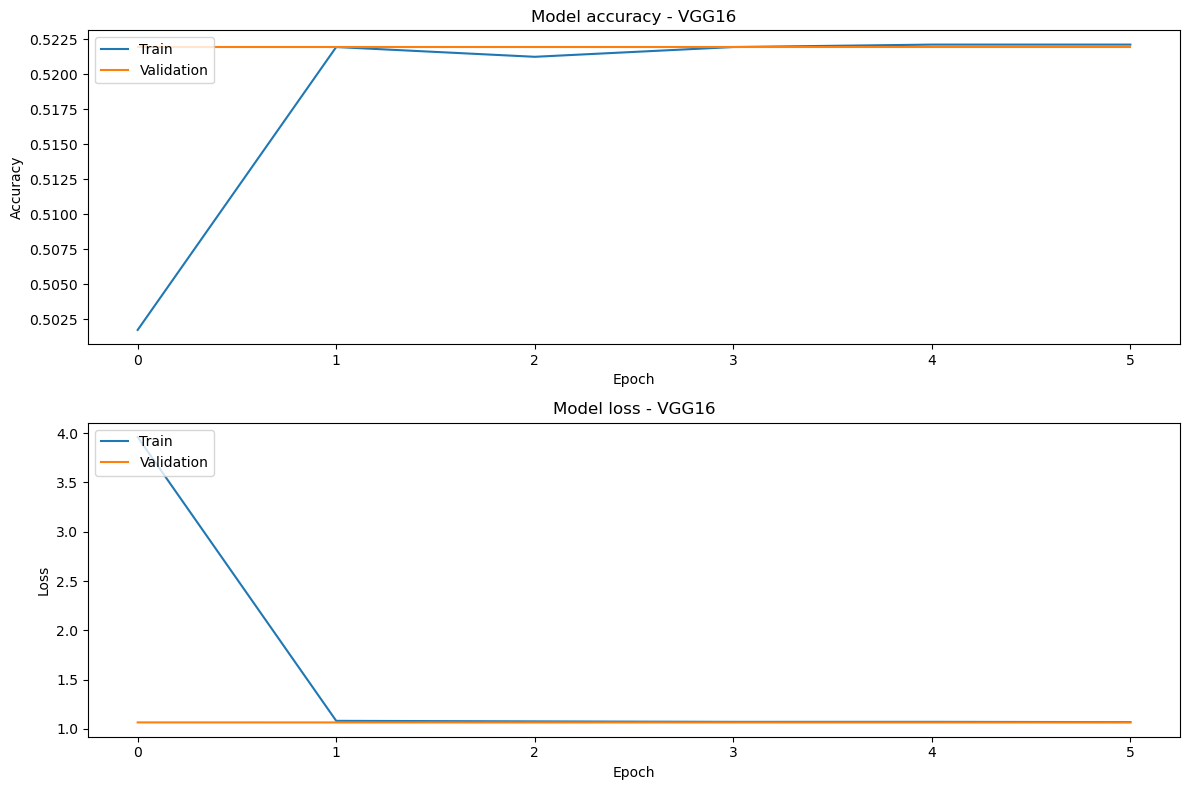

VGG16 model and history saved in directory: ./split_datav4


In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, clone_model
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
import matplotlib.pyplot as plt
import json
import cv2
import logging
import time

LOG_FORMAT = "[%(asctime)s] [%(name)s] [%(levelname)s] %(message)s"
logging.basicConfig(format=LOG_FORMAT)
logging.getLogger("IMG").setLevel(logging.DEBUG)
log = logging.getLogger("IMG")

class PrintLogger(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"\nEpoch {epoch + 1} started.")
    
    def on_epoch_end(self, epoch, logs=None):
        print(f"\nEpoch {epoch + 1} ended.")
        print(f"Accuracy: {logs['accuracy']:.4f} - Loss: {logs['loss']:.4f} - Val Accuracy: {logs['val_accuracy']:.4f} - Val Loss: {logs['val_loss']:.4f}")

class ImageBatcher:
    def __init__(self, images, batch_size: int, image_size: int, shuffle: bool, drop_last: bool, max_batch: int = 0) -> None:
        log.info("Initializing image batcher")
        self.images = images
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.drop_last = drop_last
        self.max_batch = max_batch

        self.num_images = self.images.shape[0]
        self.shape = (batch_size, self.images.shape[1], image_size, image_size)
        self.size = int(np.prod(self.shape))
        self.dtype = self.images.dtype
        self.nbytes = self.dtype.itemsize * self.size

        log.debug(f"Image Fields... \
            \n\tNumber of images: {self.num_images} \
            \n\tType: {self.dtype} \
            \n\tBatch Shape: {self.shape} \
            \n\tBatch Size: {self.size} \
            \n\tBatch Bytes: {self.nbytes}")

        self.indices = None
        self.current_index = 0
        self.current_batch = 0
        self.epoch = 0
        self._initialize_indices()

        log.info("Successfully created image batcher")

    def _initialize_indices(self) -> None:
        log.debug(f"Initializing indices. Shuffle: {self.shuffle}")
        self.indices = np.arange(self.num_images)

        if self.shuffle:
            np.random.shuffle(self.indices)

    def __iter__(self):
        return self

    def __next__(self) -> np.ndarray:
        self.current_batch += 1

        if self.current_index >= self.num_images:
            self._batch_completed()
            raise StopIteration
        
        if self.max_batch != 0 and self.current_batch > self.max_batch:
            self._batch_completed()
            raise StopIteration
        
        start_idx = self.current_index
        end_idx = min(self.current_index + self.batch_size, self.num_images)
        batch_indices = self.indices[start_idx: end_idx]

        if self.drop_last and end_idx - start_idx != self.batch_size:
            log.debug("Skipped last batch")
            self._batch_completed()
            raise StopIteration
        
        batch_images = self._get_batch_from_dataset(batch_indices)

        self.current_index = end_idx
        return batch_images

    def _batch_completed(self) -> None:
        log.info("Batch completed")
        self.epoch += 1
        self.current_index = 0
        self.current_batch = 0

        if self.shuffle:
            np.random.shuffle(self.indices)

    def _get_batch_from_dataset(self, indices: list[int]) -> np.ndarray:
        if self.shuffle:
            batch_images = []
            for i in indices:
                batch_images.append(self.images[i])
            
            batch_images = np.stack(batch_images, axis=0)
            return self._preprocess_images(batch_images)
        else:
            batch_images = self.images[indices]
            return self._preprocess_images(batch_images)

    def _preprocess_images(self, images: np.ndarray) -> np.ndarray:
        output_size = (self.image_size, self.image_size)
        resized_images = np.empty((images.shape[0], *output_size, 3))
        resized_images = resized_images.astype(self.dtype)

        for i, image in enumerate(images):
            if image.shape[2] == 4:  # If image has 4 channels (RGBA), convert to 3 channels (RGB)
                image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)
            resized_images[i] = cv2.resize(image, output_size, interpolation=cv2.INTER_LINEAR)
        
        return resized_images

# Function to resize images using the ImageBatcher
def resize_images_with_batcher(images, batch_size, image_size, shuffle=False):
    batcher = ImageBatcher(images, batch_size=batch_size, image_size=image_size, shuffle=shuffle, drop_last=False)
    resized_images = []

    for batch in batcher:
        resized_images.append(batch)

    return np.vstack(resized_images)

# Define directories
save_dir = './split_datav4'
os.makedirs(save_dir, exist_ok=True)

# Load the split data
X_rp_train = np.load(os.path.join(save_dir, 'X_rp_train.npy'))
X_gaf_train = np.load(os.path.join(save_dir, 'X_gaf_train.npy'))
X_mtf_train = np.load(os.path.join(save_dir, 'X_mtf_train.npy'))
y_train = np.load(os.path.join(save_dir, 'y_train.npy'))

X_rp_val = np.load(os.path.join(save_dir, 'X_rp_val.npy'))
X_gaf_val = np.load(os.path.join(save_dir, 'X_gaf_val.npy'))
X_mtf_val = np.load(os.path.join(save_dir, 'X_mtf_val.npy'))
y_val = np.load(os.path.join(save_dir, 'y_val.npy'))

X_rp_test = np.load(os.path.join(save_dir, 'X_rp_test.npy'))
X_gaf_test = np.load(os.path.join(save_dir, 'X_gaf_test.npy'))
X_mtf_test = np.load(os.path.join(save_dir, 'X_mtf_test.npy'))
y_test = np.load(os.path.join(save_dir, 'y_test.npy'))

# Resize images using ImageBatcher
X_rp_train = resize_images_with_batcher(X_rp_train, batch_size=32, image_size=224)
X_gaf_train = resize_images_with_batcher(X_gaf_train, batch_size=32, image_size=224)
X_mtf_train = resize_images_with_batcher(X_mtf_train, batch_size=32, image_size=224)
X_rp_val = resize_images_with_batcher(X_rp_val, batch_size=32, image_size=224)
X_gaf_val = resize_images_with_batcher(X_gaf_val, batch_size=32, image_size=224)
X_mtf_val = resize_images_with_batcher(X_mtf_val, batch_size=32, image_size=224)
X_rp_test = resize_images_with_batcher(X_rp_test, batch_size=32, image_size=224)
X_gaf_test = resize_images_with_batcher(X_gaf_test, batch_size=32, image_size=224)
X_mtf_test = resize_images_with_batcher(X_mtf_test, batch_size=32, image_size=224)

# Define a function to build the VGG16 model
def build_vgg16_model(input_shape, num_classes):
    inputs_rp = Input(shape=input_shape, name='input_rp')
    inputs_gaf = Input(shape=input_shape, name='input_gaf')
    inputs_mtf = Input(shape=input_shape, name='input_mtf')

    base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

    base_rp = clone_model(base_model)
    base_rp._name = 'base_rp'
    base_rp.set_weights(base_model.get_weights())
    x_rp = base_rp(inputs_rp)
    x_rp = Flatten(name='flatten_rp')(x_rp)

    base_gaf = clone_model(base_model)
    base_gaf._name = 'base_gaf'
    base_gaf.set_weights(base_model.get_weights())
    x_gaf = base_gaf(inputs_gaf)
    x_gaf = Flatten(name='flatten_gaf')(x_gaf)

    base_mtf = clone_model(base_model)
    base_mtf._name = 'base_mtf'
    base_mtf.set_weights(base_model.get_weights())
    x_mtf = base_mtf(inputs_mtf)
    x_mtf = Flatten(name='flatten_mtf')(x_mtf)

    merged = Concatenate(name='concat')([x_rp, x_gaf, x_mtf])

    x = Dense(512, activation='relu', name='dense_512')(merged)
    x = Dropout(0.5, name='dropout_512')(x)
    x = Dense(128, activation='relu', name='dense_128')(x)
    x = Dropout(0.5, name='dropout_128')(x)
    outputs = Dense(num_classes, activation='softmax', name='output')(x)

    model = Model(inputs=[inputs_rp, inputs_gaf, inputs_mtf], outputs=outputs)
    return model

# Define input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 4

# Build VGG16 model
vgg16_model = build_vgg16_model(input_shape, num_classes)
vgg16_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
vgg16_checkpoint = ModelCheckpoint(filepath=os.path.join(save_dir, 'vgg16_best_model.keras'), monitor='val_loss', save_best_only=True)

# Create TensorFlow Datasets
batch_size = 4
train_dataset = tf.data.Dataset.from_tensor_slices(((X_rp_train, X_gaf_train, X_mtf_train), y_train)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices(((X_rp_val, X_gaf_val, X_mtf_val), y_val)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices(((X_rp_test, X_gaf_test, X_mtf_test), y_test)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

# Train VGG16 model
vgg16_history = vgg16_model.fit(
    train_dataset,
    epochs=10, validation_data=val_dataset,
    callbacks=[early_stopping, vgg16_checkpoint, PrintLogger()],
    verbose=1
)

# Evaluate VGG16 model on the test set
vgg16_model.load_weights(os.path.join(save_dir, 'vgg16_best_model.keras'))
vgg16_test_loss, vgg16_test_accuracy = vgg16_model.evaluate(test_dataset)
print(f'VGG16 Test loss: {vgg16_test_loss:.4f}')
print(f'VGG16 Test accuracy: {vgg16_test_accuracy:.4f}')

# Function to plot learning curves
def plot_learning_curve(history, model_name):
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model accuracy - {model_name}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(2, 1, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model loss - {model_name}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Plot learning curve for VGG16
plot_learning_curve(vgg16_history, 'VGG16')

# Save the final VGG16 model
vgg16_model.save(os.path.join(save_dir, 'vgg16_model.keras'))

# Save the training history
with open(os.path.join(save_dir, 'vgg16_history.json'), 'w') as f:
    json.dump(vgg16_history.history, f)

print(f"VGG16 model and history saved in directory: {save_dir}")


In [15]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.set_memory_growth(physical_devices[0], True)


AttributeError: module 'tensorflow._api.v2.config' has no attribute 'set_memory_growth'

In [1]:
import gc
import tensorflow as tf
from tensorflow.keras import backend as K

# Trigger garbage collection
gc.collect()

# Clear TensorFlow session
K.clear_session()

# Reset the default graph (for TensorFlow 1.x)
tf.compat.v1.reset_default_graph()

# Free up memory in TensorFlow
tf.compat.v1.Session().close()

# Alternatively, use the following if you are using TensorFlow 2.x:
tf.keras.backend.clear_session()


2024-07-07 15:17:40.228715: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-07 15:17:40.420702: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-07 15:17:40.420763: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-07 15:17:40.455345: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-07 15:17:40.516845: I tensorflow/core/platform/cpu_feature_guar